In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import visualization_utils

In [2]:
#! pip install seaborn==0.12.0

In [3]:
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240527/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed/tl_tf_multi_coronaviridae_s_uniref90_sars_cov_2.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
    df[pred_diff_col] = df[human_label] - orig_pred_val
    df["perturb_pos"] = df["perturb_pos"] + 1
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    
    return df

In [7]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [8]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)


In [9]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred
0,3.646653e-08,0.000455,0.282759,0.000003,0.000108,0.318339,0.396981,0.001354,WIV04,Human,K,1038,J,-0.190584,0.190584,Human,Human
1,2.361889e-08,0.000448,0.208778,0.000002,0.000094,0.221644,0.568144,0.000890,WIV04,Human,P,1112,W,-0.019422,0.019422,Human,Human
2,2.533365e-08,0.000429,0.207266,0.000002,0.000088,0.210399,0.580933,0.000882,WIV04,Human,S,875,V,-0.006632,0.006632,Human,Human
3,2.377062e-08,0.000423,0.204186,0.000002,0.000085,0.206074,0.588371,0.000860,WIV04,Human,E,309,J,0.000806,0.000806,Human,Human
4,2.991777e-08,0.000481,0.211196,0.000002,0.000102,0.217975,0.569302,0.000942,WIV04,Human,K,1149,M,-0.018263,0.018263,Human,Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,2.450005e-08,0.000441,0.204738,0.000002,0.000089,0.207360,0.586517,0.000853,WIV04,Human,G,107,S,-0.001048,0.001048,Human,Human
31822,2.492062e-08,0.000437,0.202999,0.000002,0.000089,0.203417,0.592199,0.000857,WIV04,Human,R,21,I,0.004634,0.004634,Human,Human
31823,2.439060e-08,0.000423,0.205308,0.000002,0.000086,0.207725,0.585589,0.000867,WIV04,Human,Q,954,I,-0.001976,0.001976,Human,Human
31824,2.565461e-08,0.000411,0.205916,0.000002,0.000085,0.208276,0.584421,0.000889,WIV04,Human,Y,396,F,-0.003145,0.003145,Human,Human


In [10]:
sarscov2_ids = perturbed_output_df["uniref90_id"].unique()
len(sarscov2_ids)

1

# Overview

### Distribution of Human class difference

In [11]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [12]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 208 (0.6535536982341482)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.446499 -0.405990      1    0.003142
1  -0.405990 -0.365481      4    0.012568
2  -0.365481 -0.324972     20    0.062842
3  -0.324972 -0.284463      8    0.025137
4  -0.284463 -0.243954     26    0.081694
5  -0.243954 -0.203445      9    0.028279
6  -0.203445 -0.162936     10    0.031421
7  -0.162936 -0.122427     13    0.040847
8  -0.122427 -0.081918     33    0.103689
9  -0.081918 -0.041409    163    0.512160
10 -0.041409 -0.000900  12753   40.071011
11 -0.000900  0.039609  18278   57.431031
12  0.039609  0.080118    340    1.068309
13  0.080118  0.120627    103    0.323635
14  0.120627  0.161136     34    0.106831
15  0.161136  0.201645     21    0.065984
16  0.201645  0.242154      8    0.025137
17  0.242154  0.282663      1    0.003142
18  0.282663  0.323172      0    0.000000
19  0.323172  0.363681      1    

<Figure size 432x288 with 0 Axes>

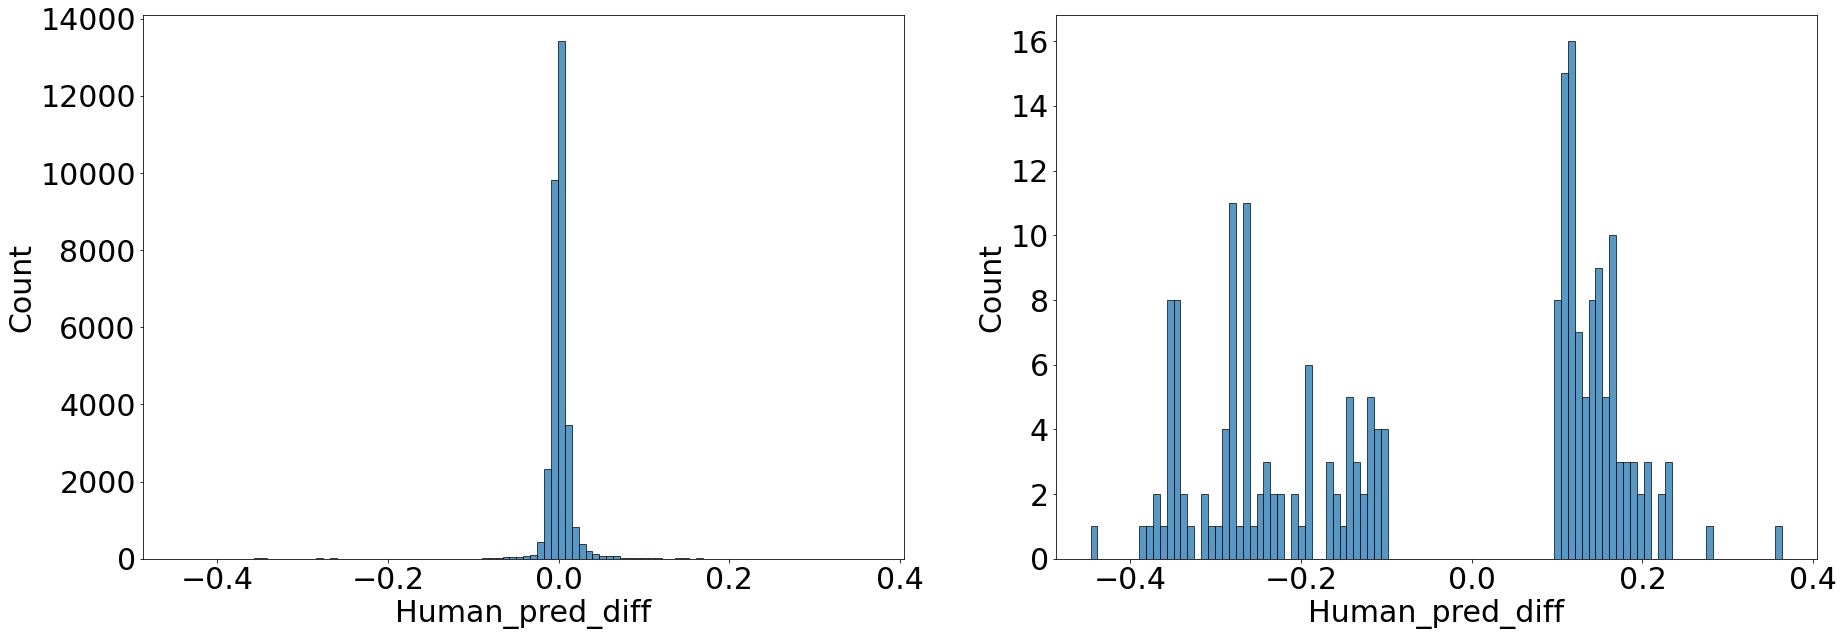

In [13]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

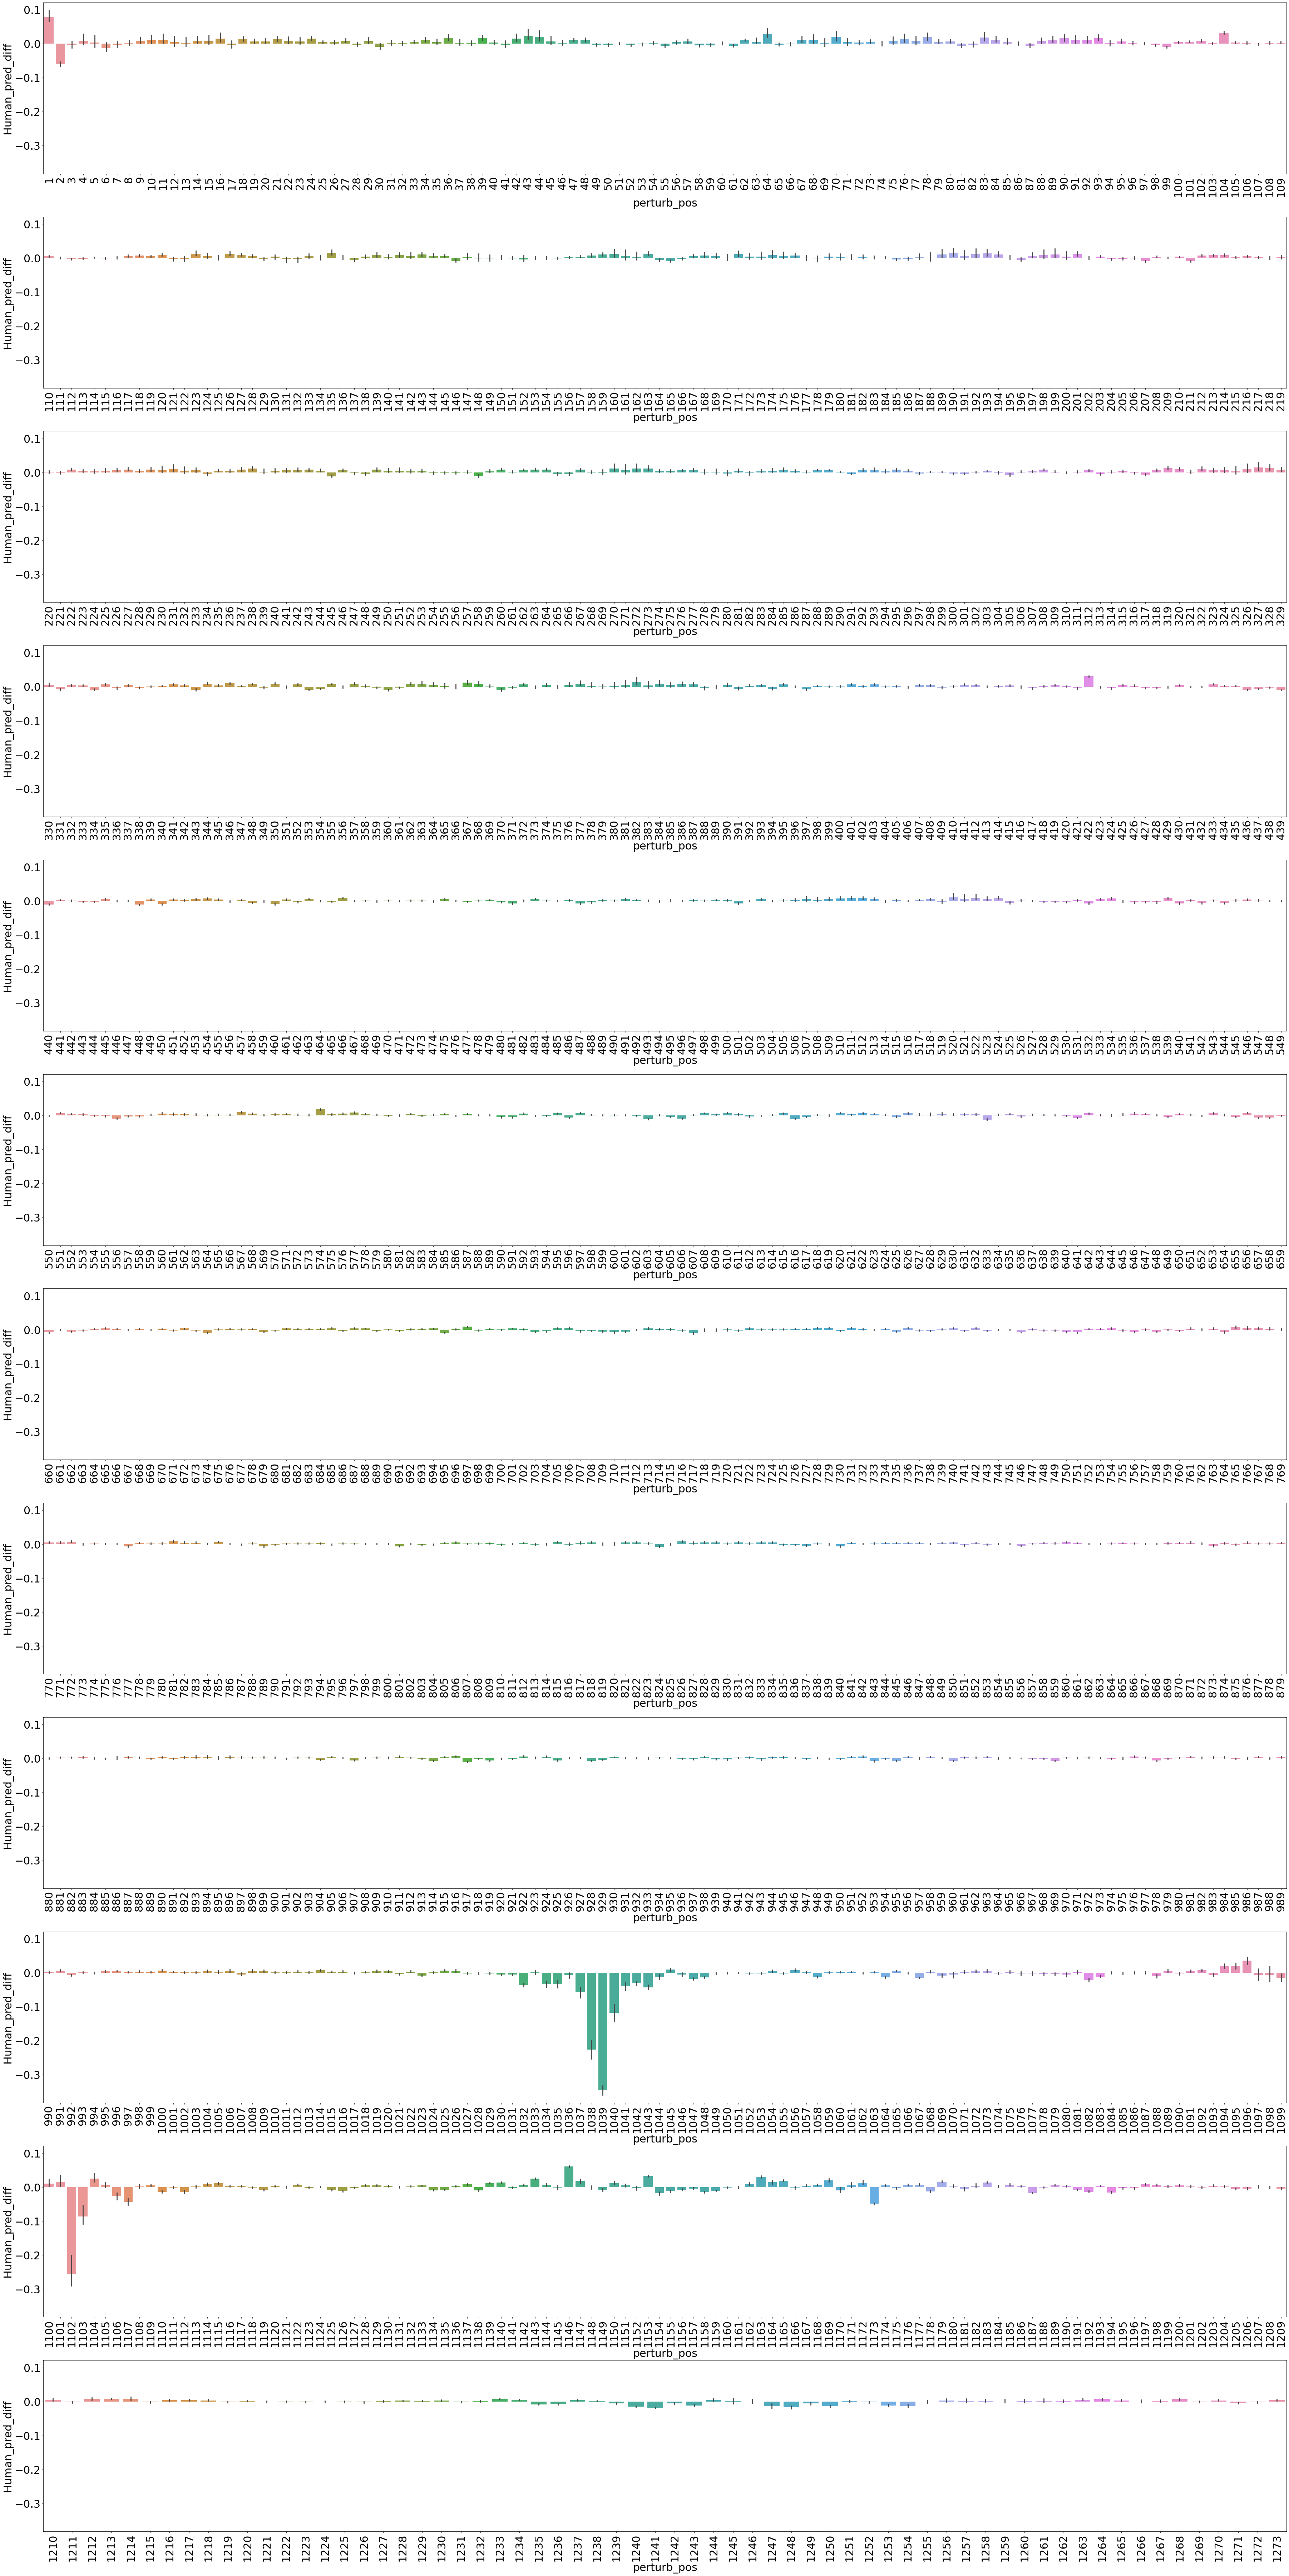

In [14]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_pos"] >= i) & (perturbed_output_df["perturb_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

### Cut-off: mean=0 and variance=0

In [15]:
mean_std_df = perturbed_output_df.groupby("perturb_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_pos"].nunique()

1273

### Cut-off: abs_Human_pred_diff >= 0.1

In [16]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.05]
cut_off_pos_1 = set(cut_off_df_1["perturb_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1273
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 303
1 intersection 2: 303
1 minus 2: 970
2 minus 1: 0
is 2 subset of 1: True


<Figure size 432x288 with 0 Axes>

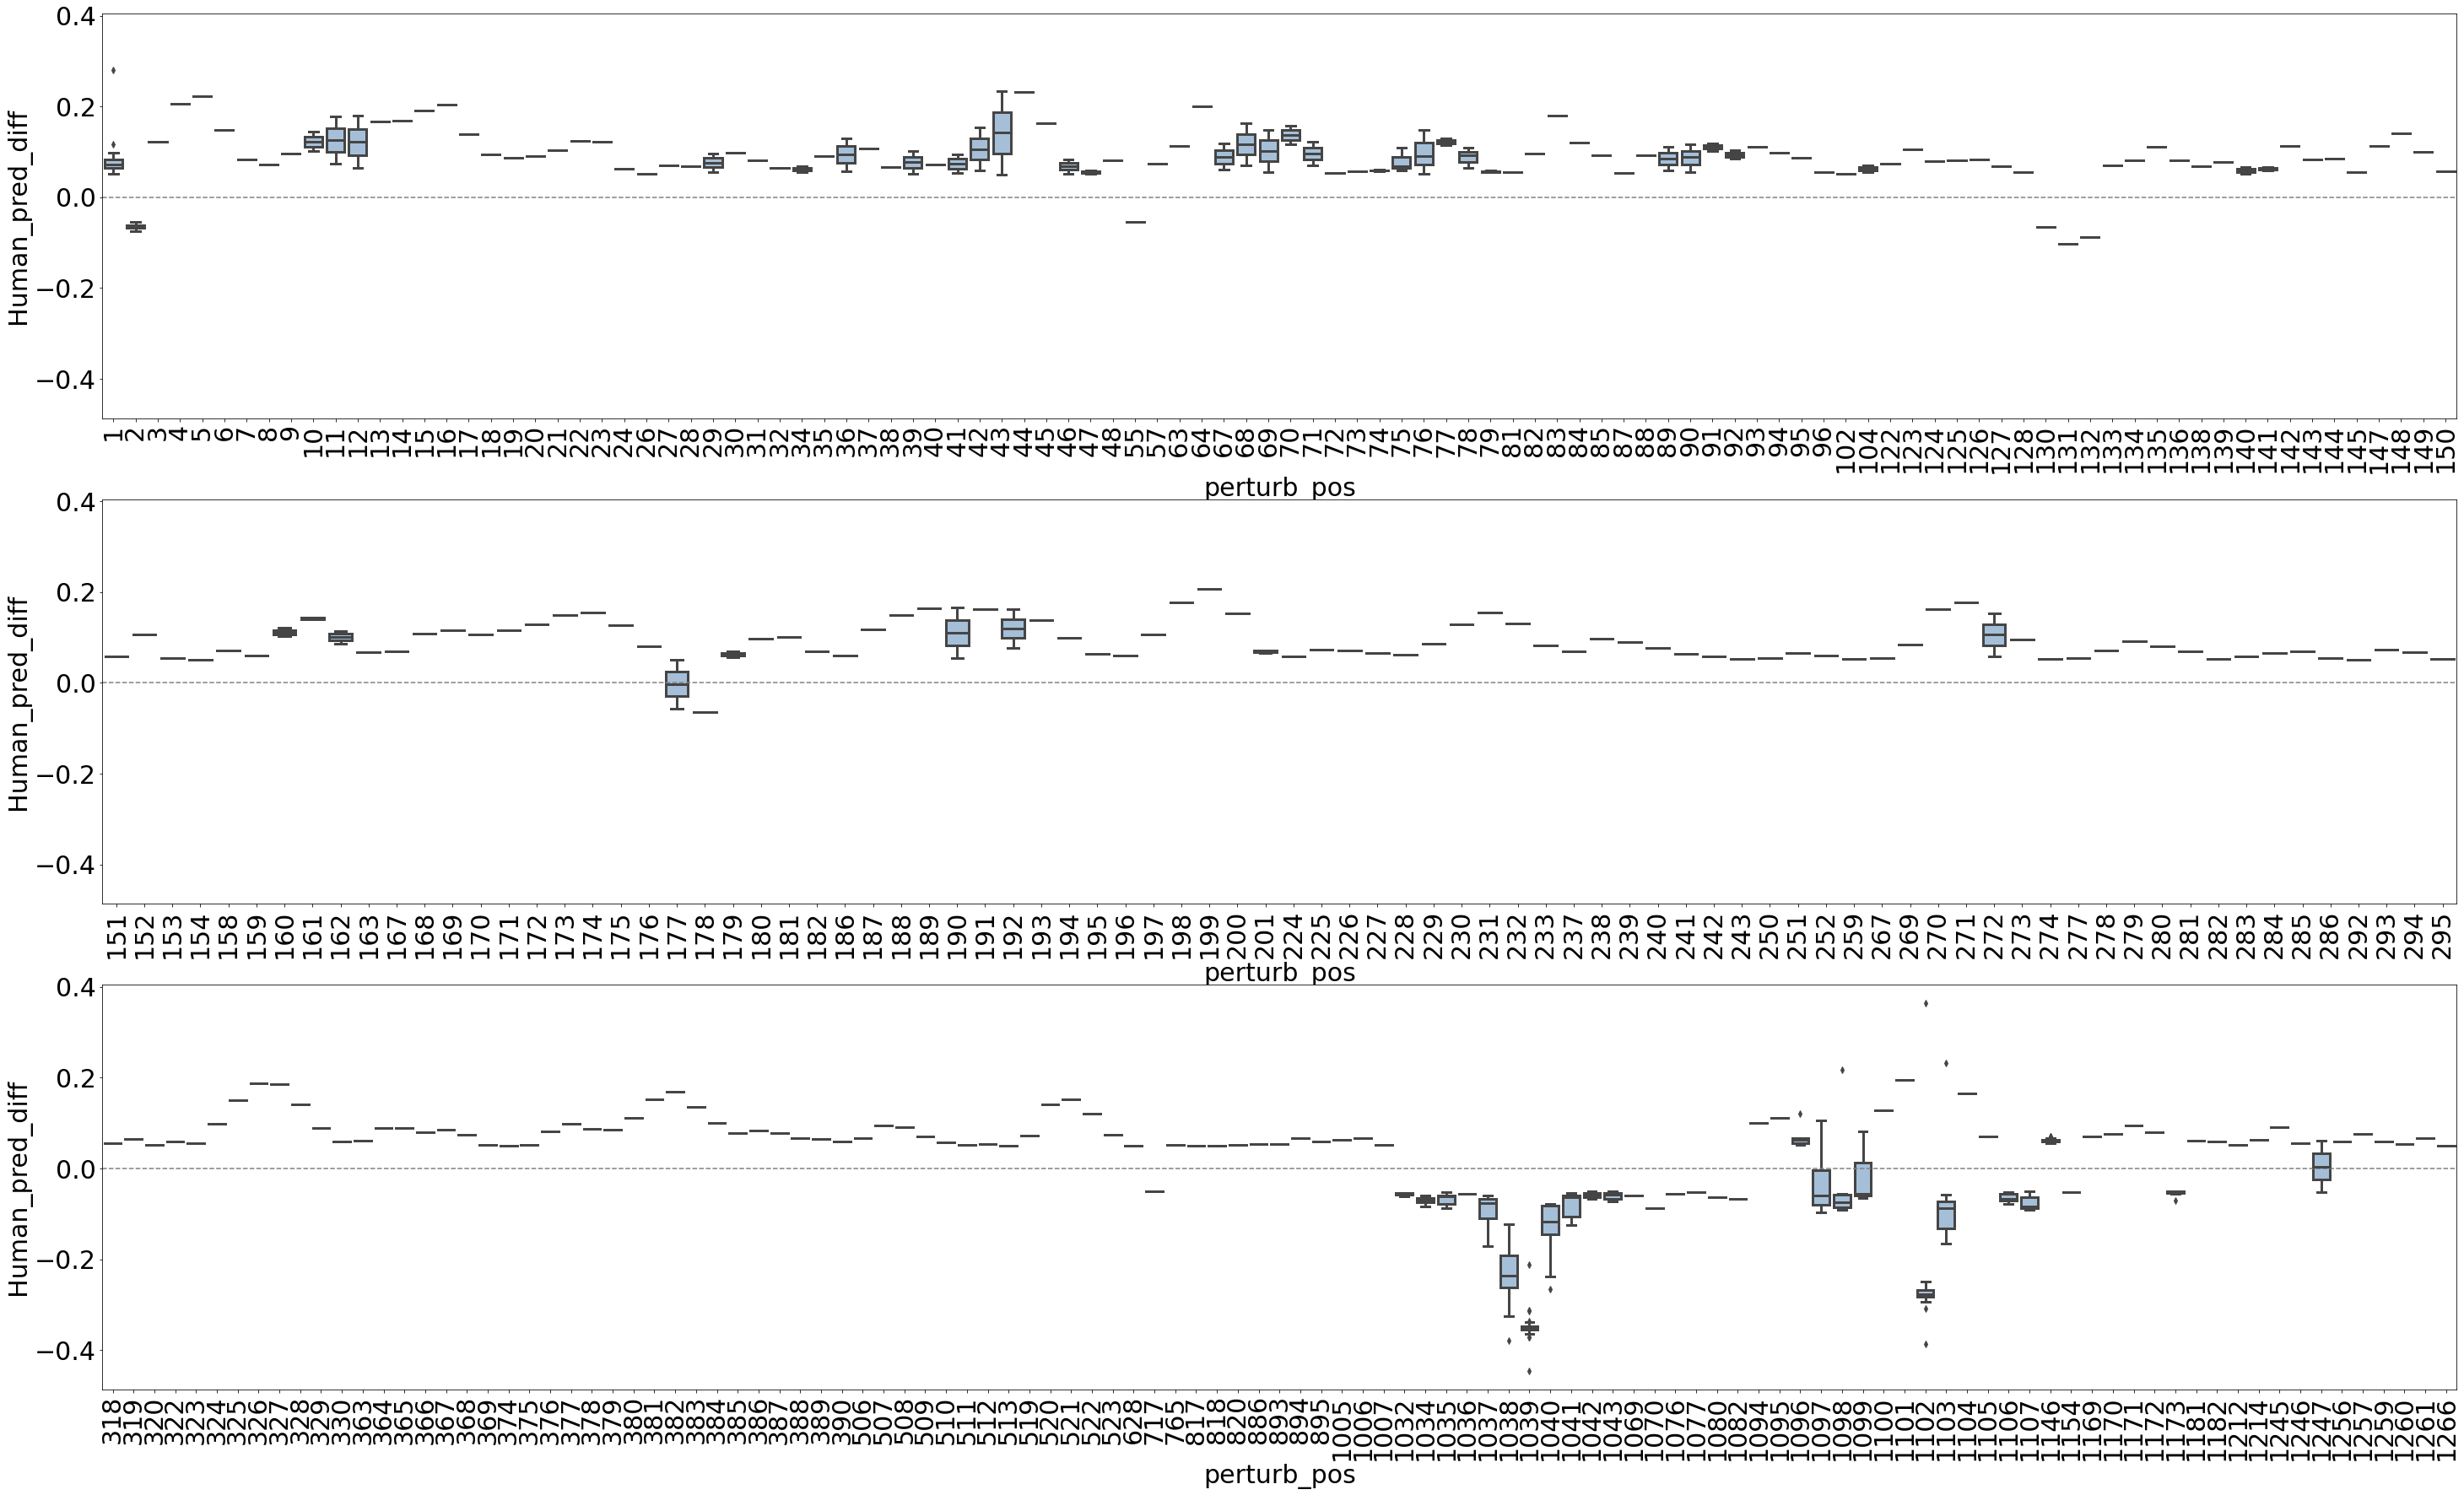

In [17]:
plt.clf()
fig, axs = plt.subplots(3, 1, figsize=(50, 30), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_pos"] <= 150],  y="Human_pred_diff", x="perturb_pos", ax=axs[0], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[0].tick_params(axis='x', rotation=90)
axs[0].axhline(0.0, color="gray", linestyle="--")

sns.boxplot(data=cut_off_df_2[(cut_off_df_2["perturb_pos"] > 150) & (cut_off_df_2["perturb_pos"] <= 300)],  y="Human_pred_diff", x="perturb_pos", ax=axs[1], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[1].tick_params(axis='x', rotation=90)
axs[1].axhline(0.0, color="gray", linestyle="--")

sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_pos"] > 300],  y="Human_pred_diff", x="perturb_pos", ax=axs[2], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[2].tick_params(axis='x', rotation=90)
axs[2].axhline(0.0, color="gray", linestyle="--")
#sns.stripplot(data=cut_off_df_2, x="Human_pred_diff", y="perturb_seq_pos", hue="new_token", orient="h", s=10, ax=axs[1], linewidth=1)

plt.show()


### Important positions causing class change from Human

59
40.67796610169492


<Figure size 432x288 with 0 Axes>

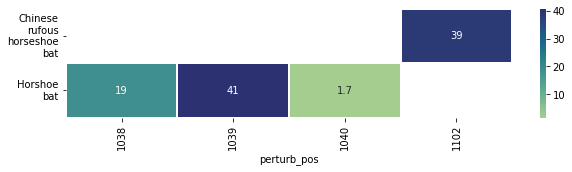

In [34]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_pos", "new_y_pred"]].groupby(["perturb_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(10, 2), sharey=True)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.heatmap(data=df.set_index("perturb_pos").T, linewidth=.1, cmap="crest", ax=axs, vmax=max_val, annot=True)
visualization_utils.wrap_ticklabels(ax=axs, axis="y", label_width=10, break_long_words=True)
axs.tick_params(axis='x', rotation=90)


# sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
# wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
# axs[1].tick_params(axis='x', rotation=90)
# plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

59


<Figure size 432x288 with 0 Axes>

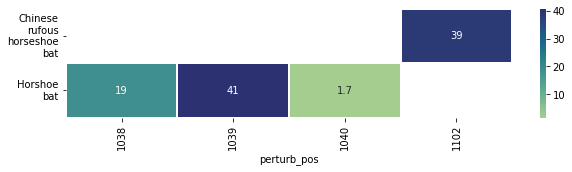

In [35]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_pos", "new_y_pred"]].groupby(["perturb_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(10, 2))
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest", annot=True)
visualization_utils.wrap_ticklabels(ax, axis="y", label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [36]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_3535015/3757831376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_pos"].astype("str") + cut_off_df_2["new_token"]


<Figure size 432x288 with 0 Axes>

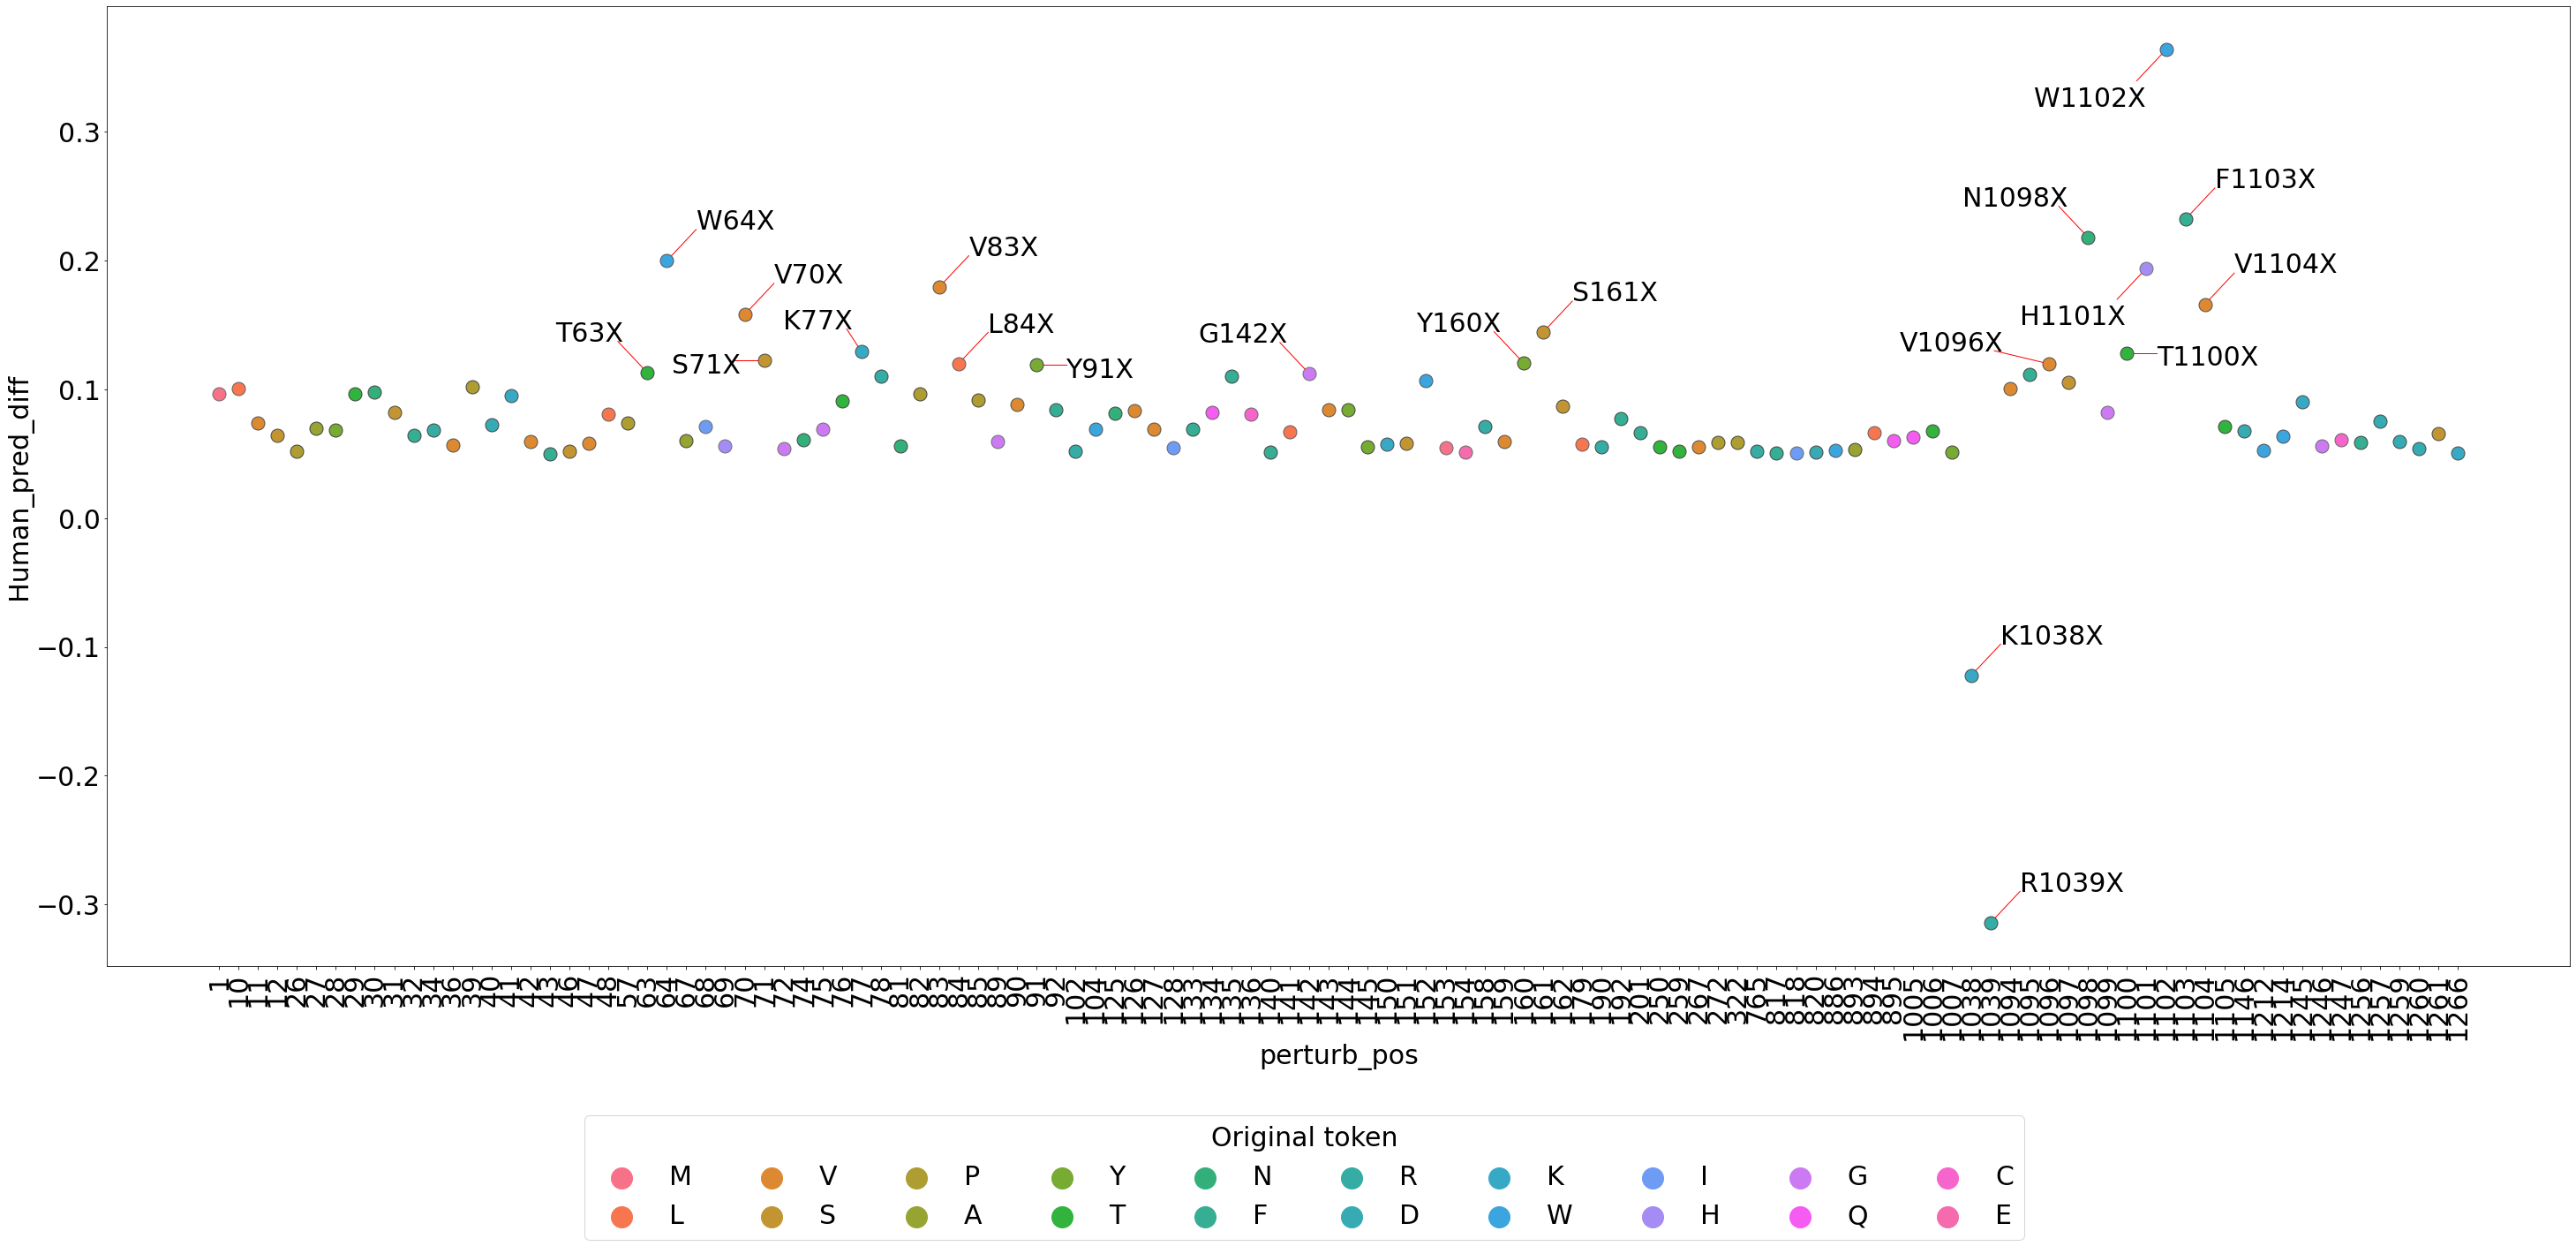

In [37]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(50, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [38]:
annotate_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturbation_id
24324,4.953862e-09,0.000117,0.031778,2.834400e-07,0.000017,0.016701,0.951247,0.000139,WIV04,Human,W,1102,X,0.363681,0.363681,Human,Human,W1102X
4047,5.458458e-08,0.000495,0.332252,4.449098e-06,0.000131,0.391638,0.273621,0.001860,WIV04,Human,R,1039,X,-0.313945,0.313945,Human,Horshoe bat,R1039X
17716,1.207979e-08,0.000259,0.100205,7.926665e-07,0.000046,0.079433,0.819652,0.000405,WIV04,Human,F,1103,X,0.232087,0.232087,Human,Human,F1103X
16153,1.221478e-08,0.000266,0.107303,7.932330e-07,0.000045,0.086504,0.805481,0.000400,WIV04,Human,N,1098,X,0.217915,0.217915,Human,Human,N1098X
8946,1.533521e-08,0.000334,0.116040,9.125105e-07,0.000055,0.095729,0.787406,0.000434,WIV04,Human,W,64,X,0.199840,0.199840,Human,Human,W64X
23183,1.455348e-08,0.000314,0.118912,8.851671e-07,0.000050,0.098584,0.781719,0.000421,WIV04,Human,H,1101,X,0.194153,0.194153,Human,Human,H1101X
21718,1.547716e-08,0.000332,0.125194,9.958953e-07,0.000058,0.106860,0.767054,0.000501,WIV04,Human,V,83,X,0.179488,0.179488,Human,Human,V83X
29203,1.762445e-08,0.000376,0.131161,1.082916e-06,0.000063,0.114228,0.753649,0.000522,WIV04,Human,V,1104,X,0.166083,0.166083,Human,Human,V1104X
26688,1.606049e-08,0.000343,0.135223,1.052613e-06,0.000060,0.118218,0.745616,0.000538,WIV04,Human,V,70,X,0.158050,0.158050,Human,Human,V70X
3599,1.806786e-08,0.000366,0.140863,1.163423e-06,0.000065,0.126386,0.731744,0.000574,WIV04,Human,S,161,X,0.144179,0.144179,Human,Human,S161X


### Mutations with new token NOT = X

In [39]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (490, 18)
Number of unique mutations = 490


<Figure size 432x288 with 0 Axes>

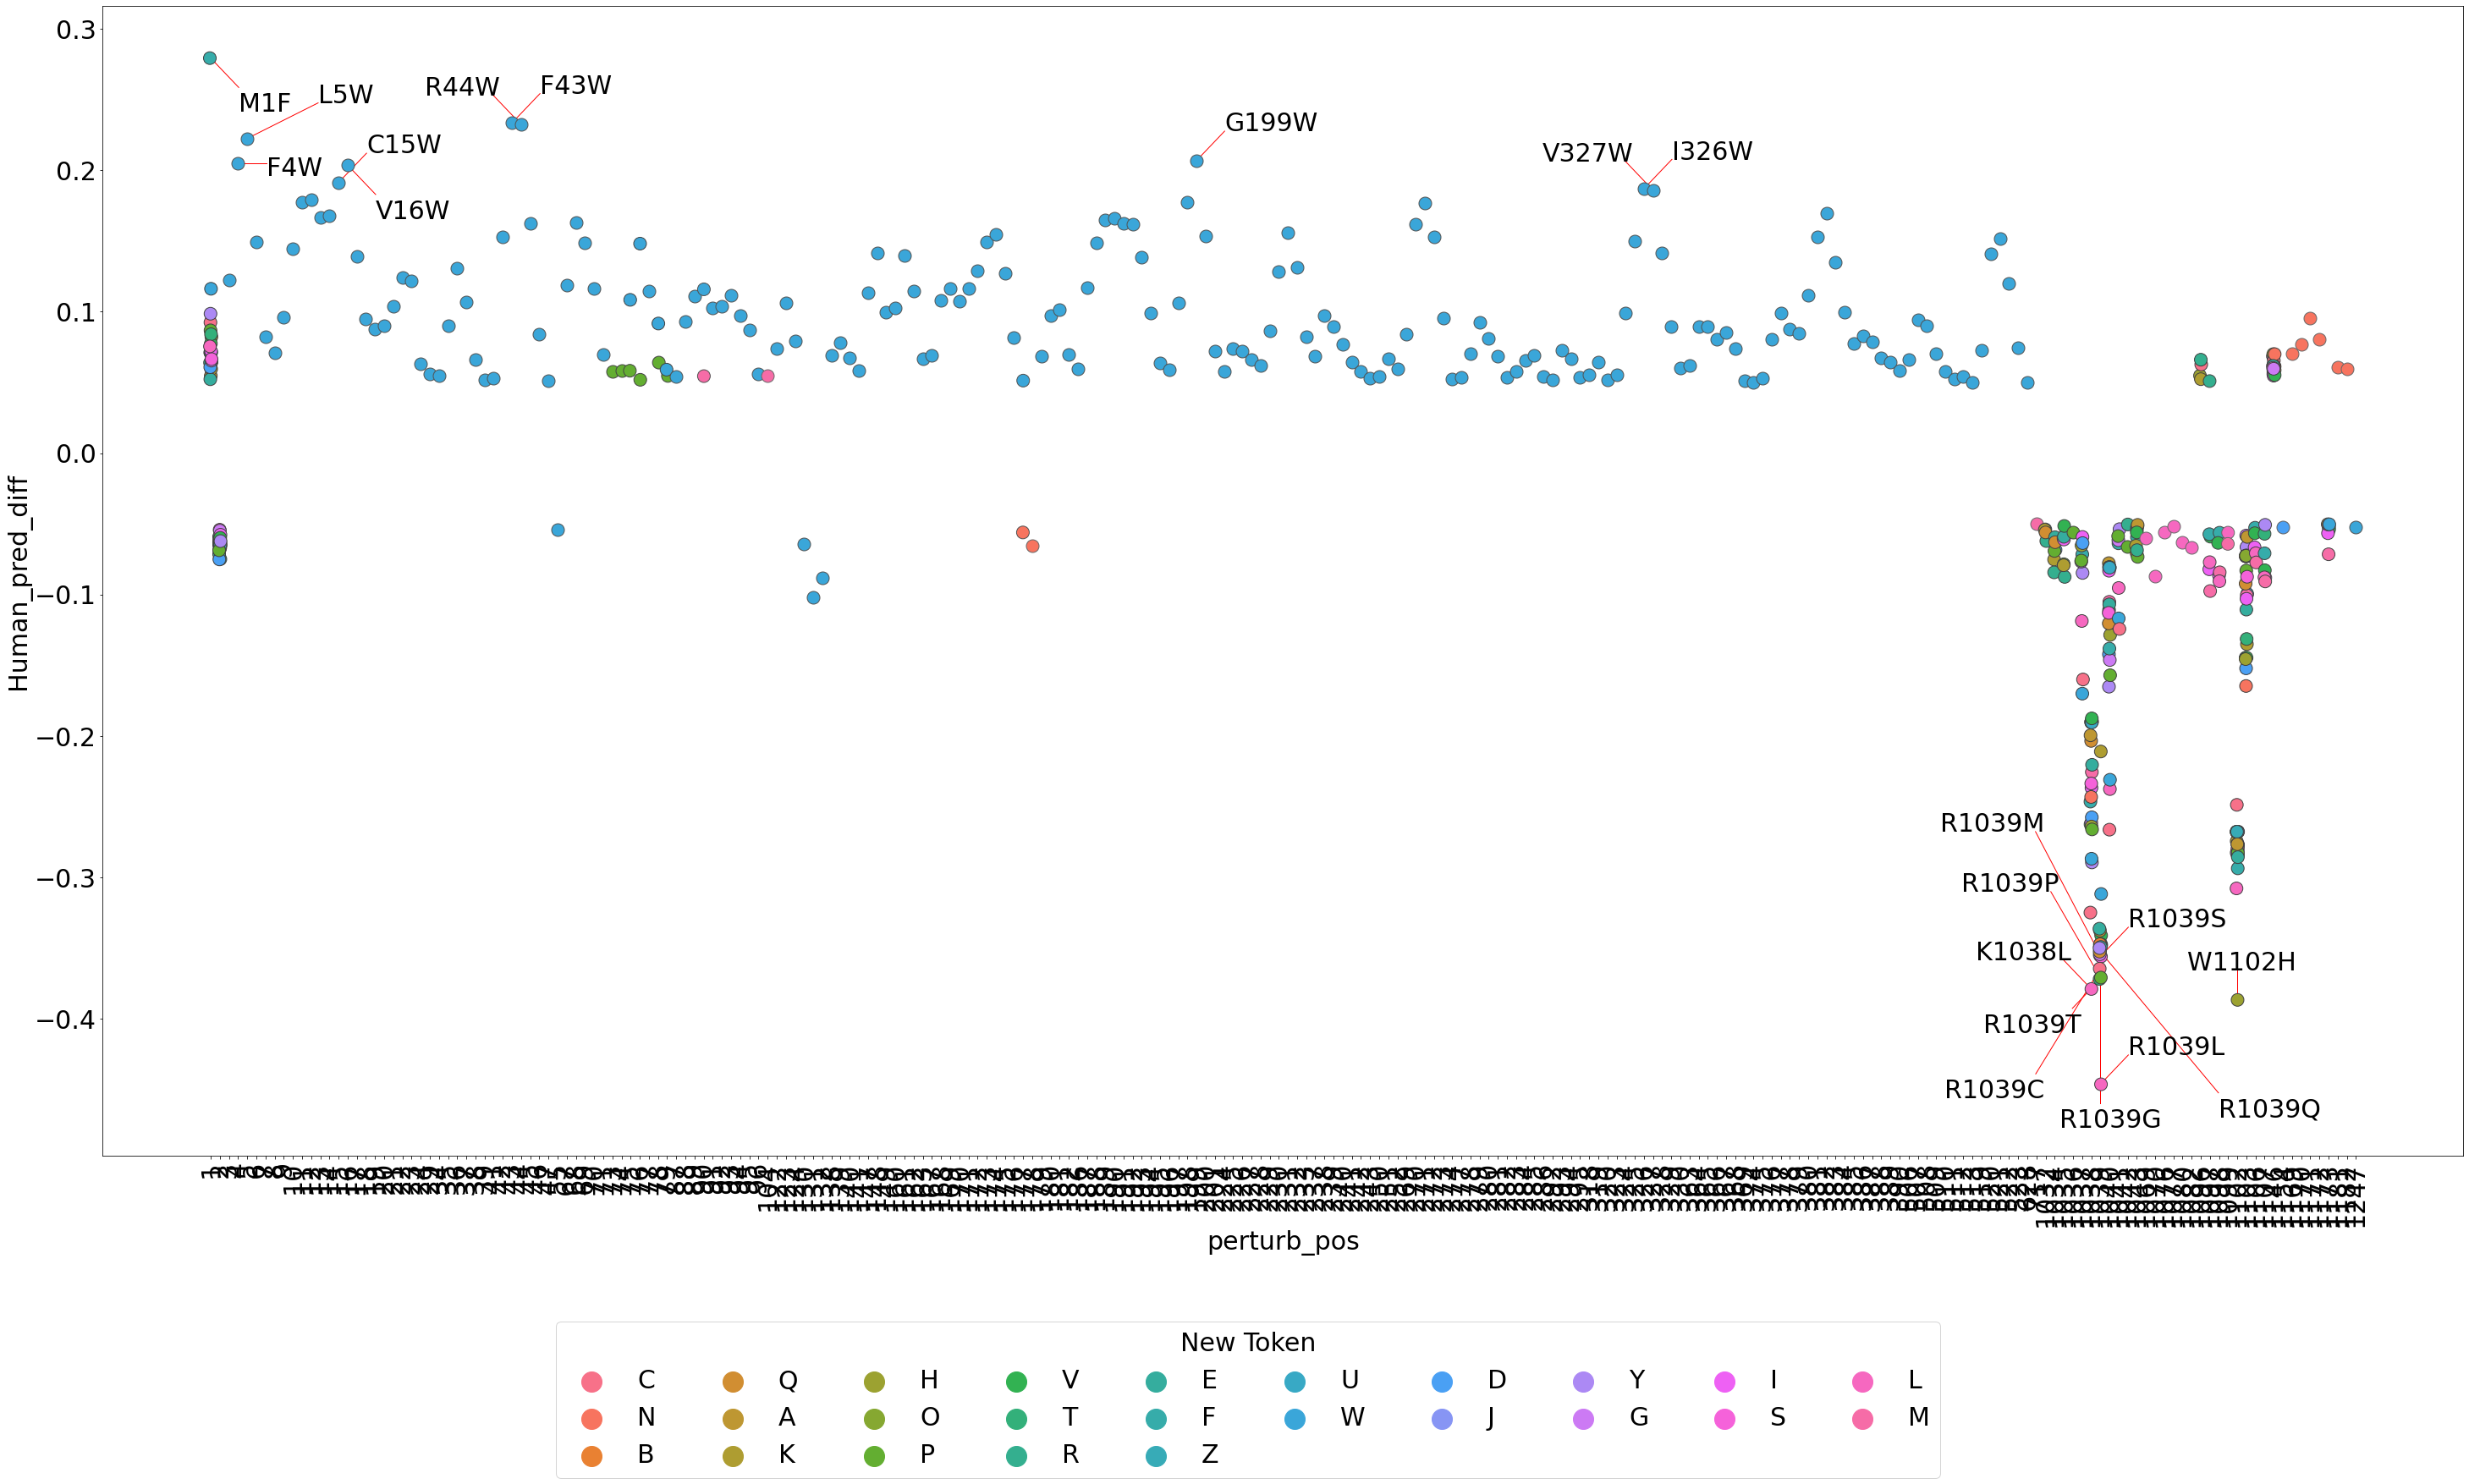

In [40]:
plt.clf()
plt.figure(figsize=(50, 25))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [41]:
cut_off_df_2["perturbation_id"].nunique()

606

<Figure size 432x288 with 0 Axes>

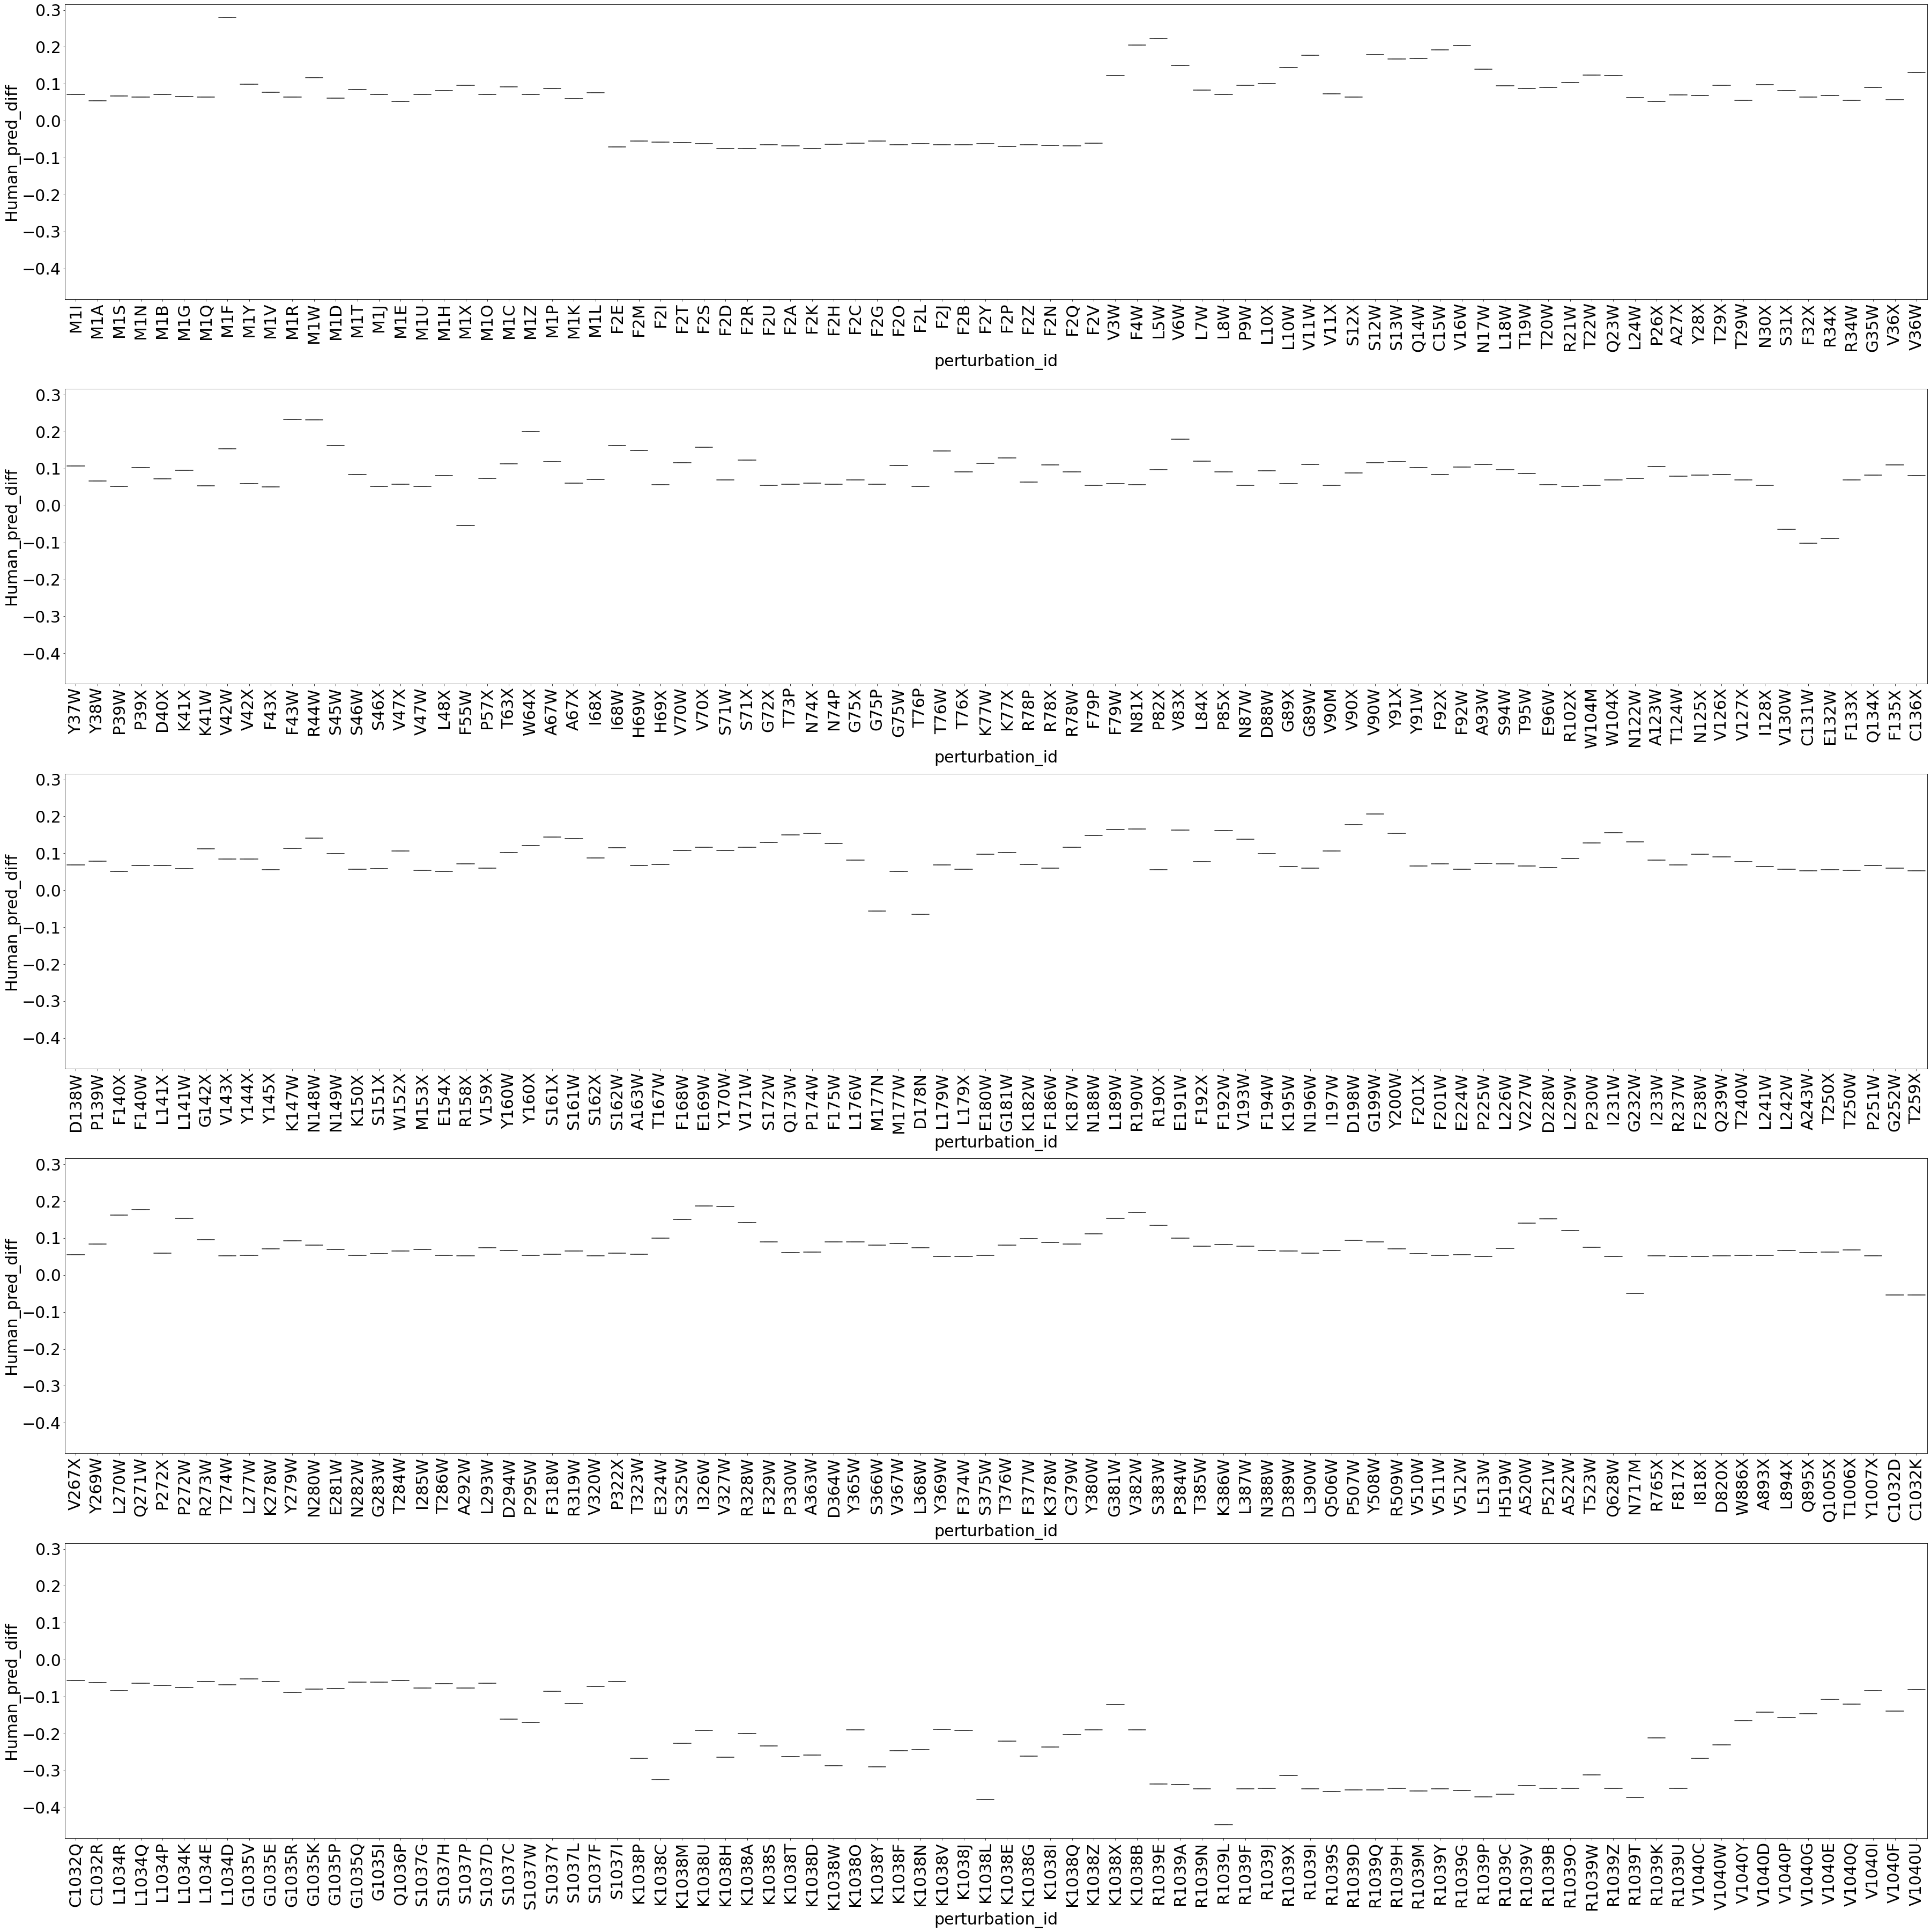

In [42]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(5, 1, figsize=(50, 50), sharex=False, sharey=True)

j = 0
for i in range(0, 426, 86):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(perturbation_ids[i:i+86])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=perturbation_ids[i:i+86],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [43]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,orig_token,pos,new_token,perturbation_id
0,D,614,G,D614G
1,S,943,P,S943P
2,E,484,K,E484K
3,N,501,Y,N501Y
4,L,452,R,L452R
5,Q,677,P,Q677P
6,Q,677,H,Q677H
7,P,681,H,P681H
8,E,484,Q,E484Q
9,K,417,N,K417N


In [44]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_pos']}{x['new_token']}", axis=1)

In [47]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

,orig_token,pos,new_token,perturbation_id,label
0,D,614,G,D614G,D614G (n=1 | 1.06%)
1,S,943,P,S943P,S943P (n=1 | 1.06%)
2,E,484,K,E484K,E484K (n=1 | 1.06%)
3,N,501,Y,N501Y,N501Y (n=1 | 1.06%)
4,L,452,R,L452R,L452R (n=1 | 1.06%)
5,Q,677,P,Q677P,Q677P (n=1 | 1.06%)
6,Q,677,H,Q677H,Q677H (n=1 | 1.06%)
7,P,681,H,P681H,P681H (n=1 | 1.06%)
8,E,484,Q,E484Q,E484Q (n=1 | 1.06%)
9,K,417,N,K417N,K417N (n=1 | 1.06%)


<Figure size 432x288 with 0 Axes>

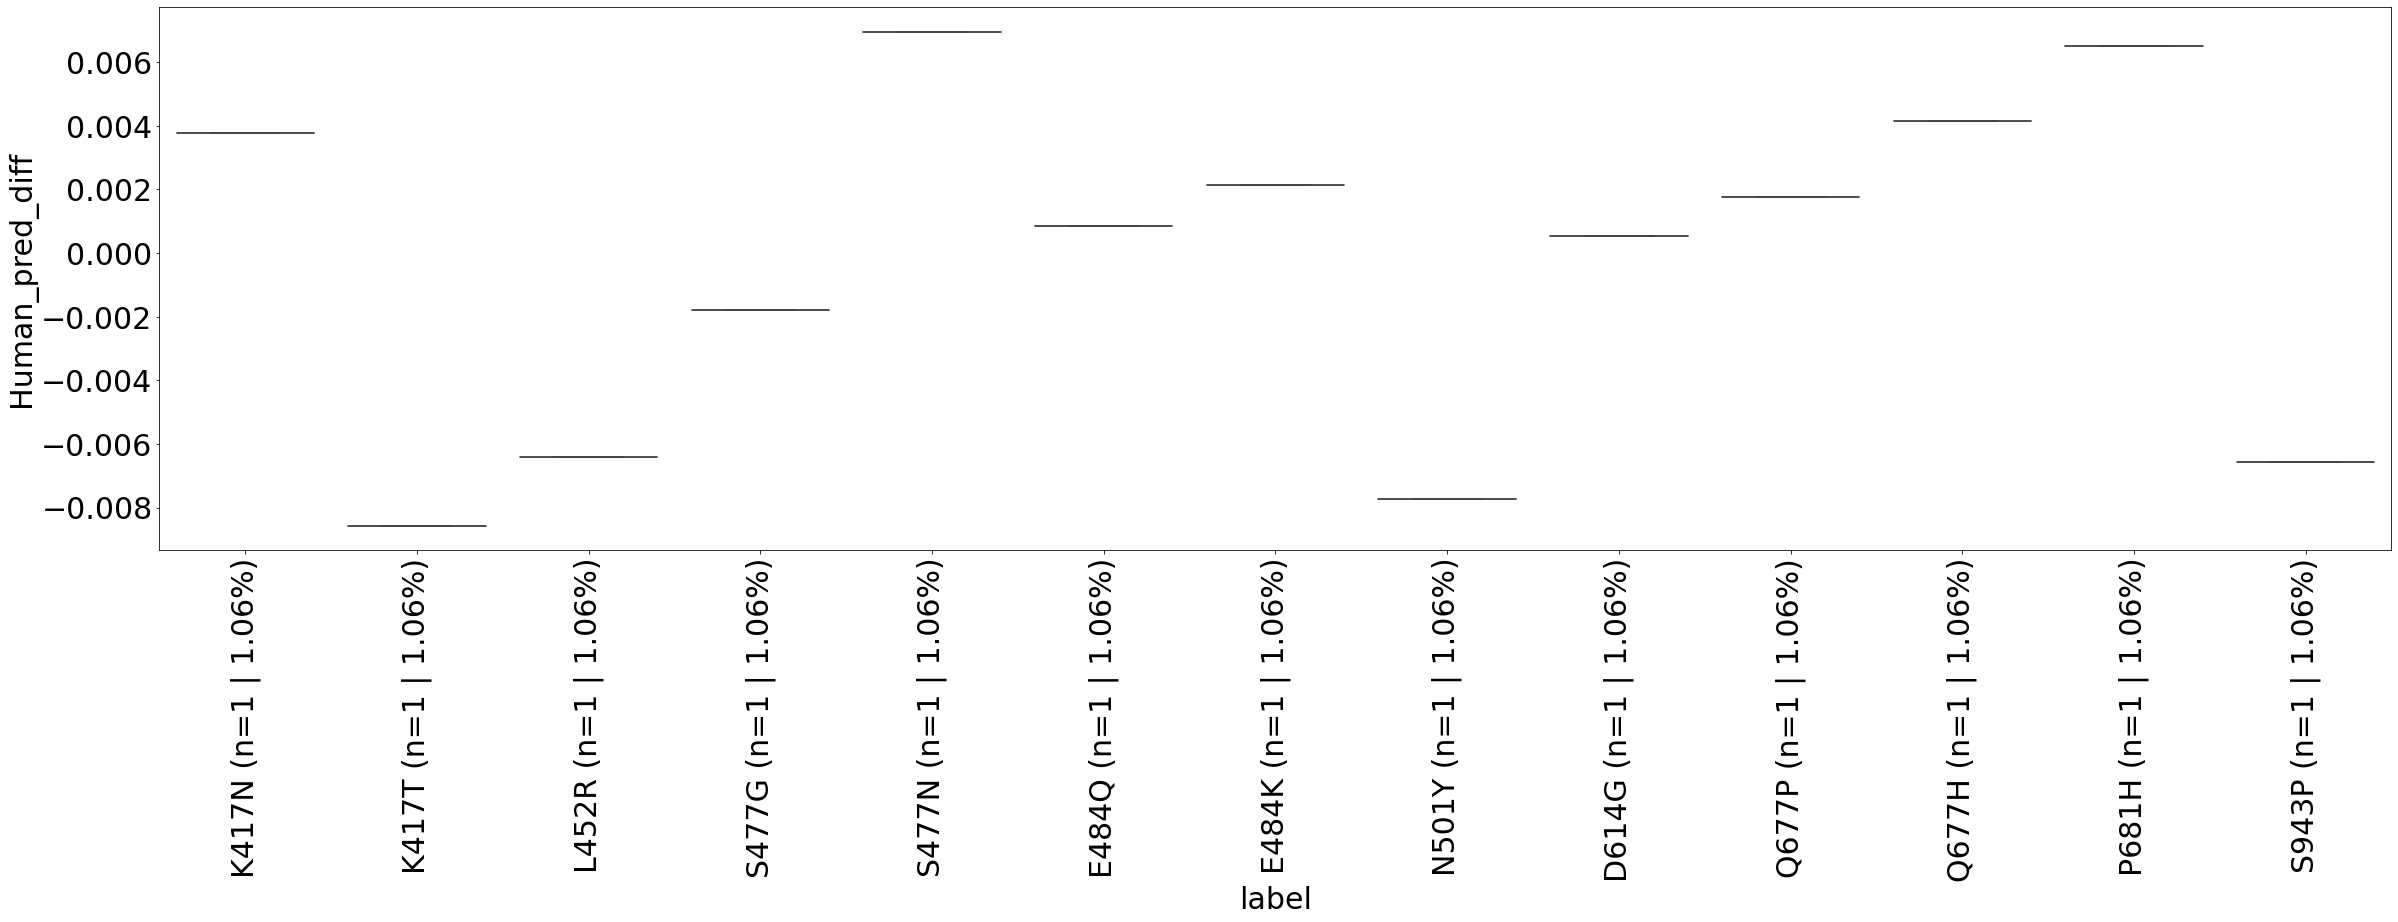

In [49]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [50]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 606
known_mutations = 13
intersection = set()


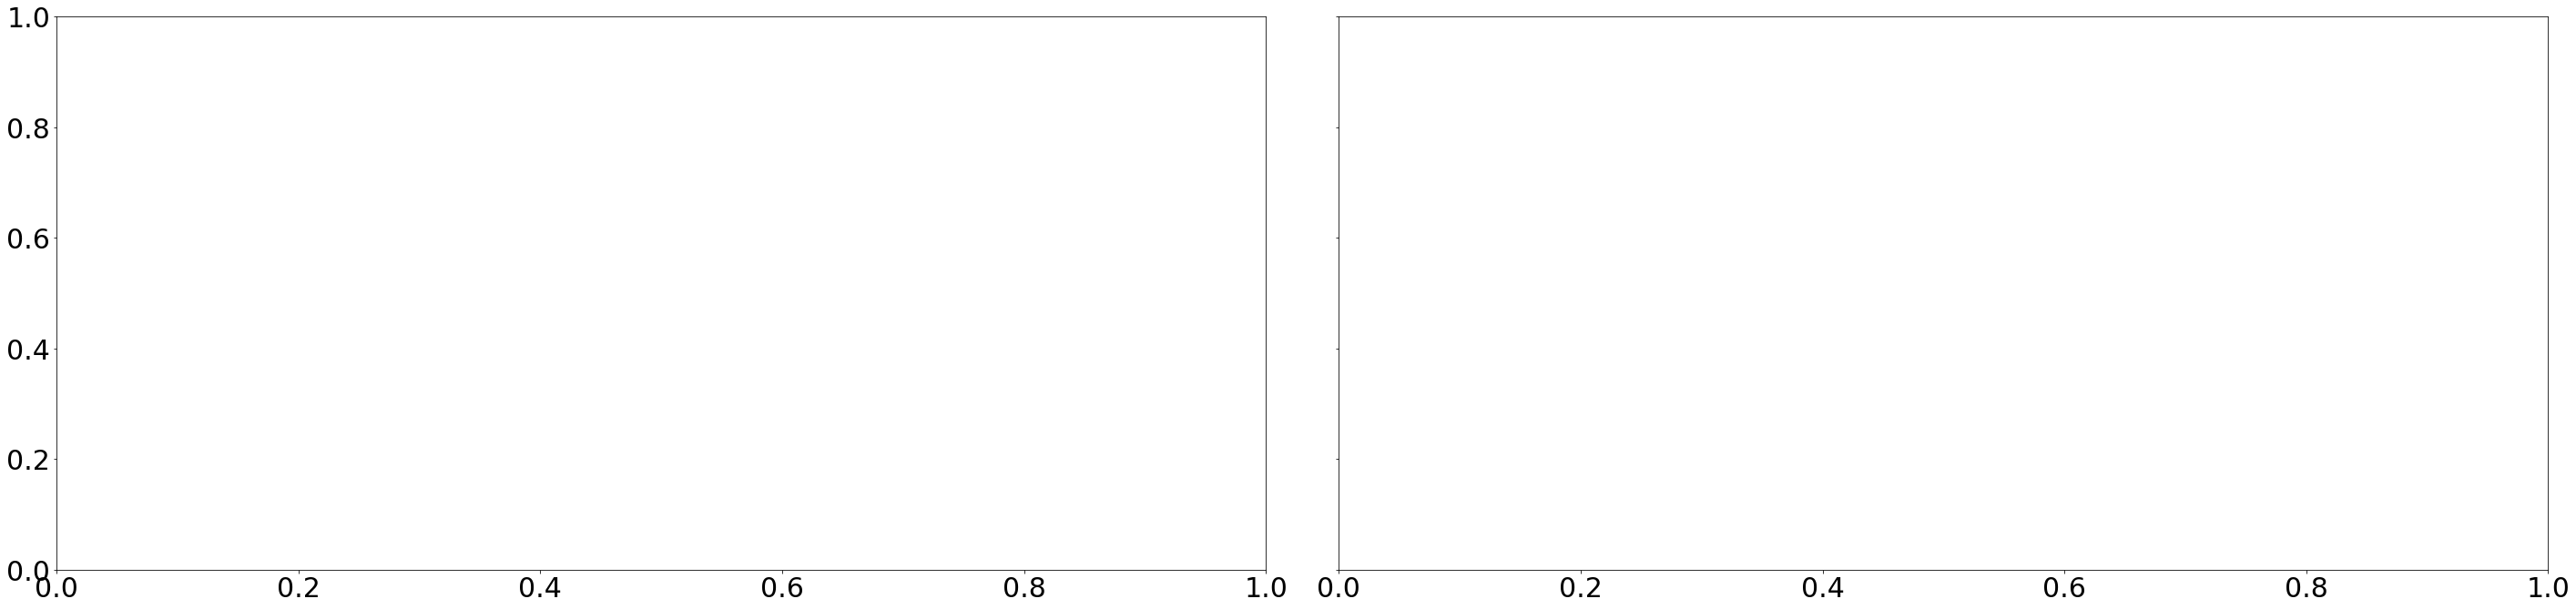

In [51]:

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

In [ ]:
mutation_mean_diff[mutation_mean_diff["mean_Human_pred_diff"] == 0]

In [ ]:
mutation_mean_diff_selected = mutation_mean_diff[(mutation_mean_diff["mean_Human_pred_diff"] > 0.1) | (mutation_mean_diff["mean_Human_pred_diff"] < -0.1)].sort_values("mean_Human_pred_diff", ascending=True)
mutation_mean_diff_selected

In [ ]:
perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])]

In [ ]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

data = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])][["perturbation_id", "Human_pred_diff"]]
ax = sns.boxplot(data=data, y="Human_pred_diff", x="perturbation_id", order=mutation_mean_diff_selected["perturbation_id"])
plt.xticks(rotation=90)
plt.show()